# 성별/나이에 따른 엘리베이터 맞춤 광고 서비스 

* 1) 엘리베이터에 승객이 탑승하고 문이 닫힐 시 카메라 실행 (웹캠 실행)
* 2) 카메라 촬영 후 안면 이미지 검출 (1명,2명,3명 이상 등)
* 3) 검출된 안면 이미지별 성별/나이 예측
* 4) 예측된 정보를 바탕으로 맞춤형 광고 송출

In [1]:
import time
import mediapipe as mp
import cv2
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from keras_preprocessing.image import ImageDataGenerator
from glob import glob
import pandas as pd
import numpy as np
import time

WebCAM_MediaPipe/log_2023_7_21_13_14_15/_face_1.jpg
WebCAM_MediaPipe/log_2023_7_21_13_14_15/_face_2.jpg
WebCAM_MediaPipe/log_2023_7_21_13_14_15/_face_3.jpg
WebCAM_MediaPipe/log_2023_7_21_13_14_15/_face_4.jpg
Load Model...
save images 1 second...
Found 4 validated image filenames.
1/1 [==============================] - 10s 10s/step


[0.001 0.999 0.004 0.013 0.287 0.181 0.364 0.091 0.007]
성별 예측 :  F  나이 예측 :  40's
[0.02  0.981 0.002 0.031 0.307 0.11  0.384 0.057 0.01 ]
성별 예측 :  F  나이 예측 :  40's
[0.702 0.299 0.002 0.002 0.328 0.293 0.174 0.09  0.006]
성별 예측 :  M  나이 예측 :  20's
[0.151 0.849 0.001 0.001 0.025 0.093 0.366 0.351 0.027]
성별 예측 :  F  나이 예측 :  40's


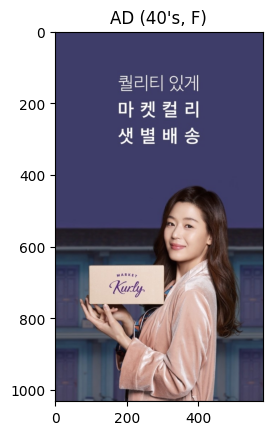

In [2]:
start_time = time.time()

# MeidaPipe 모델 선언
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# 웹캠 열기
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Camera open failed")
    exit()

# 엘리베이터 상황 가정 : 문이 열린 후,닫힐 때마다 사진 촬영 (10초마다 촬영하는 것으로 가정)
while True:
    ret, frame = cap.read()
    if not ret:
        print("Can't read camera")
        break

    # 현재 시간
    now = datetime.now()
    now_path = 'log_'+str(now.year) + '_' + str(now.month) + '_' + str(now.day) + '_' + str(now.hour) + '_' + str(now.minute) + '_' + str(now.second) +'/'

    
    # 웹캠에서 프레임 읽기
    ret, frame = cap.read()
    if not ret:
        print("Can't read camera")
        break

    root_save_path = 'WebCAM_MediaPipe/'

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # MediaPipe를 활용한 안면 검출을 위해 BGR에서 RGB로
        results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # results.detections : 검출된 1개 이상의 안면 이미지지
        if results.detections:
            
            # 안면 검출 이미지 리스트
            cropped_images = [] 
            zoom_factor = 0.1

            for face_id, detection in enumerate(results.detections):
                
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = frame.shape
                # 안면 검출된 좌표 계산
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                # 전체 이미지(frame)에서 얼굴 이미지 슬라이싱
                face_roi = frame[y:y + h, x:x + w]

                # 슬라이싱 확대하기 (CNN 학습데이터와 유사한 Margin)
                expand_width = int(face_roi.shape[0]*0.3)
                expand_height = int(face_roi.shape[1]*0.3)
                # expand_height = int(face_roi.shape[1]*0.15)

                face_roi = frame[np.clip(y-expand_height,0,480):np.clip(y+h+expand_height,0,480),np.clip(x-expand_width,0,640):np.clip(x + w+expand_width,0,640)]


                # CNN Multi-Label에 input하기 위한 resize
                resized_face = cv2.resize(face_roi, (224, 224),fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
                cropped_images.append(resized_face)

    people_num = 0

    try :
        for idx, cropped_image in enumerate(cropped_images):
            people_num += 1
            resized_cropped_image = cv2.resize(cropped_image, (224, 224))

            isExist = os.path.exists(root_save_path+now_path)
            if not isExist:
                os.makedirs(root_save_path+now_path)
            output_filename = root_save_path+now_path + '_face_' + str(idx+1) + '.jpg' 
            print(output_filename)

            cv2.imwrite(output_filename, resized_cropped_image)

        print("Load Model...")
        model = load_model("C:/Users/user/Desktop/models/DensNet_best_model2.h5")
        img_path = ["img_path"]
        sex = ["M", "F"]
        ages = ["0's","10's","20's","30's","40's","50's","60+"]
        
        column_names = img_path+sex+ages

        test_datagen=ImageDataGenerator(rescale=1./255.)
        preprocessed_data_path = root_save_path+now_path

        img_paths = glob(preprocessed_data_path+'*.jpg')

        img_names = []
        for img_path in img_paths:
            tmp = img_path.split("\\")[-1]
            img_names.append(tmp)

        test_df = pd.DataFrame(columns=column_names)
        test_df['img_path'] = img_names
        test_df = test_df.fillna(0)

        values = [0 for _ in range(9)]

        print("save images 1 second...")
        # time.sleep(1)

        test_generator=test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=preprocessed_data_path,
            x_col='img_path',
            # y_col=column_names,
            batch_size=people_num,
            seed=777,
            shuffle=False,
            color_made='rgb',
            class_mode=None,
            target_size=(224,224))

        preds = model.predict(test_generator)

        dict_preds = {"0's, M":0,"10's, M":0,"20's, M":0,"30's, M":0,"40's, M":0,"50's, M":0,"60+, M":0,
                      "0's, F":0,"10's, F":0,"20's, F":0,"30's, F":0,"40's, F":0,"50's, F":0,"60+, F":0}

        print("\n")
        for pred in preds:
            print(np.round(pred,3))
            sex_pred = sex[np.argmax(pred[:2])]
            pred = pred[2:]
            age_pred = ages[np.argmax(pred)]
            print("성별 예측 : ",sex_pred," 나이 예측 : ",age_pred)
            
            dict_preds[age_pred+', '+sex_pred] += 1

        # print(dict_preds)

        max_value = 0
        max_label = ''
        for k in dict_preds.keys():
            if dict_preds[k] > max_value:
                max_label = k

        ads = os.listdir('ad/'+max_label)
        ads_cnt = len(ads)
        ran_idx = np.random.randint(0,ads_cnt)
        ad_img = cv2.imread('ad/'+max_label+'/'+ads[ran_idx])

        plt.title('AD '+'('+str(max_label)+')')
        plt.imshow(cv2.cvtColor(ad_img, cv2.COLOR_BGR2RGB))

        # 광고 지속10초
        time.sleep(10)
        # 테스트
        break
    
    except e:
        print(e)
        print("No one detected!")
        break

# 웹캠 해제
cap.release()
cv2.destroyAllWindows()